## Details

The notebook contains the synthetic data experiment with high noise (sigma^2 = 0.5) and low noise (sigma^2 = 00.5) for HNTF (Cichocki et al.). Due to the non-convexity of the HNCPD task, results will vary run to run, so the results from this notebook will not exactly match those in the paper.

In [1]:
# loading packages and functions
import sys
import itertools

sys.path.append("./src")
import torch
import numpy as np
from matplotlib import pyplot as plt

from NNCPD import outer_product, outer_product_np
from utils import *
#
import torch.nn as nn
from torch.autograd import Variable
from writer import Writer

from sklearn.decomposition import NMF

import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac, non_negative_parafac

Using numpy backend.


In [2]:
def cichocki(X, r, to_transpose=(0,1,2), seed=None):
    """
    Given a 3-mode tensor X and a list of rank r, computes to Chichocki 
    """
    np.random.seed(1)
    #factors = non_negative_parafac(X, r[0], n_iter_max=2000, tol=0)[1]

    factors = non_negative_parafac(X, r[0])
    A, D, S = factors[to_transpose[0]], factors[to_transpose[1]], factors[to_transpose[2]]
    
    factorizations = [[A, D, S]]
    
    for i in range(1, len(r)):
        
        #factors = non_negative_parafac(outer_product_np(np.identity(r[i-1]), D, S), r[i], n_iter_max=2000, tol=0)[1]
        if type(seed) == type(None):
            factors = non_negative_parafac(outer_product_np(np.identity(r[i-1]), D, S), r[i])
        else:
            factors = non_negative_parafac(outer_product_np(np.identity(r[i-1]), D, S), r[i], init="random", random_state=seed)
        A, D, S = factors[0], factors[1], factors[2]
        factorizations.append([A,D,S])
        
    return factorizations  

In [3]:
def run_cichocki_factorization(X, ranks, S_trues, to_transpose=(0,1,2), X_orig=None, seed=None, verbose=True, display=True):#, S_true=None, S_func=S_func_1):
    
    factorizations = cichocki(X, ranks, to_transpose=to_transpose, seed=seed)
    
    X = np.transpose(X, to_transpose)
    
    if X_orig is not None:
        X_orig = np.transpose(X_orig, to_transpose)
    
    recon_losses = []
    recon_losses_orig = []
    topic_losses = []
    
    for i in range(len(factorizations)):

        A = factorizations[0][0]
        for j in range(1, i+1):
            A = A @ factorizations[j][0]

        _, D, S = factorizations[i]

        approx = outer_product_np(A,D,S)

        relative_loss = np.linalg.norm(np.ndarray.flatten(X-approx), 2)  / np.linalg.norm(np.ndarray.flatten(X), 2)
        
        if X_orig is not None:
            relative_loss_orig = np.linalg.norm(np.ndarray.flatten(X_orig-approx), 2)  / np.linalg.norm(np.ndarray.flatten(X_orig), 2)
            recon_losses_orig.append(relative_loss_orig)
        
        if(verbose):
            print("Layer", i+1, "Relative reconstruction loss:", relative_loss)

        recon_losses.append(relative_loss)

        if(display):
            display_tensor(approx, figsize=(8,4))
      
    Ss = [factorizations[1][0] @ factorizations[2][0], factorizations[1][0], factorizations[2][0]]
    for i, S in enumerate(Ss):

        best_value = measure_modeling((S.T / np.sum(S, axis=1)).T, S_trues[i])
        topic_losses.append(best_value)
        
        best_value, best_i, best_j = find_fit((S.T / np.sum(S, axis=1)).T, S_trues[i])
            
    if(display):
        display_topic_matrices(Ss, S_trues)

    if X_orig is not None:
        return recon_losses, recon_losses_orig, topic_losses
    else:
        return recon_losses, topic_losses

In [4]:
def handle_losses_cichocki(recon, topic):
    
    #average_recons = np.mean(recon, axis=1)
    #average_topics = np.mean(topic, axis=1)

    average_recons = np.mean(np.mean(recon.reshape((3, 10, 3, 2)), axis=3), axis=1)
    average_topics = np.mean(np.mean(topic.reshape((3, 10, 3, 2)), axis=3), axis=1)
    
    for i in range(3):
    
        print("Topic Modeling Loss 7 to 2 (average, best, worst):", average_topics[0][i])
        print("Topic Modeling Loss 7 to 4 (average, best, worst):", average_topics[1][i])
        print("Topic Modeling Loss 4 to 2 (average, best, worst):", average_topics[2][i])
        print("")
        print("Relative Recon Loss Rank 7 (average, best, worst):", average_recons[0][i])
        print("Relative Recon Loss Rank 4 (average, best, worst):", average_recons[1][i])
        print("Relative Recon Loss Rank 2 (average, best, worst):", average_recons[2][i])
        print("")


## Generate Data Tensor (Low Noise)

In [5]:
X = get_synthetic_tensor(seed=14, noise=0.4)
X_original = get_synthetic_tensor(noise=0)

### Visualize Original Data Tensor

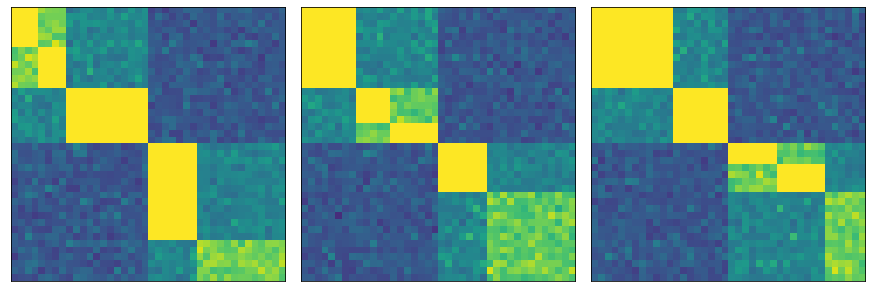

In [6]:
display_tensor(X)

In [7]:
S_trues = get_synthetic_gt_topics()

In [8]:
num_trials = 10
transposes = [(0,1,2), (0,2,1), (1,0,2), (1,2,0), (2,0,1), (2,1,0)]
ranks = [7,4,2]

all_recon_losses = np.empty((len(ranks), num_trials, len(transposes)))
all_recon_losses_orig = np.empty((len(ranks), num_trials, len(transposes)))
all_topic_losses = np.empty((len(ranks), num_trials, len(transposes)))
for i in range(num_trials):
    for j, t in enumerate(transposes):
        recon_losses, recon_losses_orig, topic_losses = run_cichocki_factorization(X, ranks, S_trues, to_transpose = t, X_orig = X_original, seed=i, verbose=False, display=False)
        all_recon_losses[:,i,j] = np.asarray(recon_losses)
        all_recon_losses_orig[:,i,j] = np.asarray(recon_losses_orig)
        all_topic_losses[:,i,j] = np.asarray(topic_losses)

In [9]:
handle_losses_cichocki(all_recon_losses_orig, all_topic_losses)

Topic Modeling Loss 7 to 2 (average, best, worst): 0.1713591307278673
Topic Modeling Loss 7 to 4 (average, best, worst): 0.14362339998429072
Topic Modeling Loss 4 to 2 (average, best, worst): 0.16985001806016436

Relative Recon Loss Rank 7 (average, best, worst): 0.45432993797409227
Relative Recon Loss Rank 4 (average, best, worst): 0.5755356801811189
Relative Recon Loss Rank 2 (average, best, worst): 0.7807949448565038

Topic Modeling Loss 7 to 2 (average, best, worst): 0.09023680913570852
Topic Modeling Loss 7 to 4 (average, best, worst): 0.11633681279957198
Topic Modeling Loss 4 to 2 (average, best, worst): 0.14161715796962507

Relative Recon Loss Rank 7 (average, best, worst): 0.45432993797409454
Relative Recon Loss Rank 4 (average, best, worst): 0.5869734002494331
Relative Recon Loss Rank 2 (average, best, worst): 0.7653047704922201

Topic Modeling Loss 7 to 2 (average, best, worst): 0.08350453695236079
Topic Modeling Loss 7 to 4 (average, best, worst): 0.11078673456943906
Topic M

Layer 1 Relative reconstruction loss: 0.2774291903373395


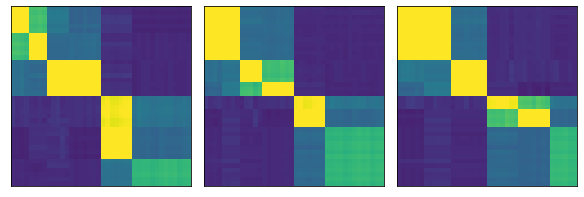

Layer 2 Relative reconstruction loss: 0.42423269714704986


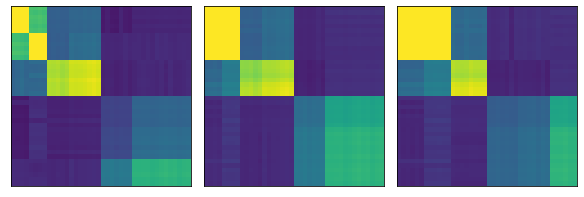

Layer 3 Relative reconstruction loss: 0.7441611122856939


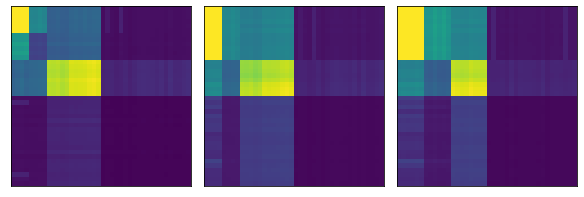

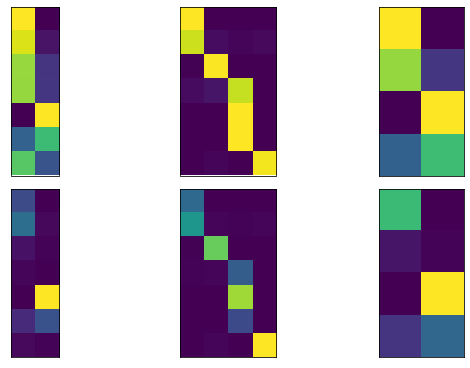

([0.2774291903373395, 0.42423269714704986, 0.7441611122856939],
 [0.2036617276441755, 0.14894673309860393, 0.1173055591837687])

In [10]:
run_cichocki_factorization(X, ranks, S_trues, seed=0)